In [121]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
import glob
import datetime as dt
from sklearn.metrics import r2_score
from tqdm.auto import tqdm

import helper_libraries.results_tools as results_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Data

In [122]:
# Load returns and spreads
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

## Visualize

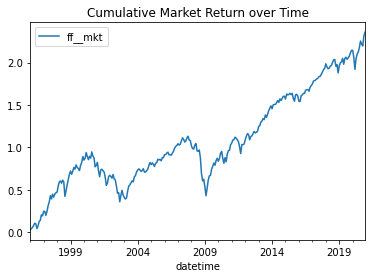

In [123]:
fret_df.groupby(pd.Grouper(freq = '1m')).sum().cumsum().plot()
plt.title('Cumulative Market Return over Time');

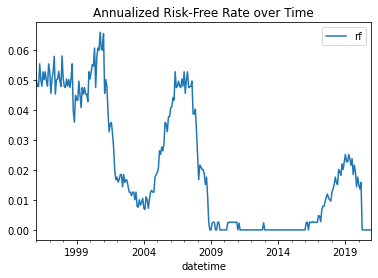

In [124]:
## Risk free
hrf_df.groupby(pd.Grouper(freq = '1m')).sum().pipe(lambda x: x*12).plot()
plt.title('Annualized Risk-Free Rate over Time');

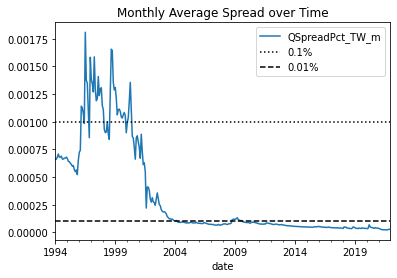

In [125]:
## Spreads
spread_df.groupby(pd.Grouper(freq = '1m')).mean().plot(y = 'QSpreadPct_TW_m')
plt.axhline(0.001, color = 'k', ls = ':', label = "0.1%")
plt.axhline(0.0001, color = 'k', ls = '--', label = "0.01%")
plt.legend()
plt.title('Monthly Average Spread over Time');

# Functions

In [126]:
def format_pd_latex_table(pd_latex_table, table_caption, table_fontsize, table_label, table_note):

    pd_latex_table = pd_latex_table.replace(r'\toprule', '\\toprule\n\\toprule')
    pd_latex_table = pd_latex_table.replace(r'\bottomrule', '\\bottomrule\n\\bottomrule')

    full_latex_table = (
        r"""
    \begin{table}[!h]
    """
        + "\\"
        + table_fontsize
        + r"""
    \centering
    \caption{"""
        + table_caption
        + r"""}
    \label{tab:"""
        + table_label
        + r"""}
    \begin{threeparttable}
    """
        + pd_latex_table
        + r"""\begin{tablenotes}[flushleft]
    \item\textit{Note:} """
        + table_note
    + r"""
    \end{tablenotes}
    \end{threeparttable}
    \end{table}
    """
    )
    
    # Get rid of extra spacing 
    full_latex_table = full_latex_table.replace('\n    ', '\n')

    return full_latex_table

In [127]:
def compute_rsquared(truth, pred):
    return 1 - np.sum(np.square(truth-pred))/np.sum(np.square(truth))

# Main

## Params

In [133]:
## Params
# List of all results folders
results_folders = (
    pd.read_excel("../../results/key.xlsx").query('"Done" in Notes')["Folder"].to_list()
)  ##### <------------------ Finish models!
# Year to start trading
start_year = "2004"

# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Tanh",
    "MS Strategy 2",
    "MS Strategy 1",
]
model_list = ["Benchmark", "LR", "LR_PCA_select", "LR_Lasso_select", "Lasso", "Enet"]

# Latex table params
table_loc = "!h"  # Should be something like htbp
table_fontsize = "footnotesize"
table_precaption = "Performance Results"
table_output_folder = "../../docs/exhibits/tables"

# Metrics and their names
metrics_list = ["Return", "ReturnAdj", "Sharpe", "SharpeAdj", "Trades", "rvol"]
metrics_names_list = [
    "Return",
    "Adjusted Return",
    "Sharpe",
    "Adjusted Sharpe",
    "Trades",
    "Realized Volatility",
]

## Process each set of results

In [135]:
for folder_name in tqdm(results_folders):

    ### Prep
    ## Get forecast data
    forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
        folder_name=folder_name,
        debug=True,
    )

    ## Get trading results
    # Filter data
    forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
    forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year)-1)].copy()
    fret_filter_df = fret_df.loc[start_year:].copy()
    hrf_filter_df = hrf_df.loc[start_year:].copy()

    # Trading strategies
    (
        oss_results_all_df,
        oss_returns_all_df,
        oss_weights_all_df,
        oss_retpred_all_df,
    ) = results_tools.get_trading_results(
        forecast_oss_filter_df,
        forecast_ins_filter_df,
        spread_df,
        fret_filter_df["ff__mkt"],
        hrf_filter_df["rf"],
        strategies_list,
        model_list,
        hold_cash=True,
    )

    ### Produce latex tables
    print("\\section{" + folder_name.replace("_", " ").title() + "}")

    ## Produce table for R2
    # Get true values
    forecast_oss_filter_df["truth"] = fret_filter_df["ff__mkt"]
    forecast_ins_filter_df["truth"] = fret_filter_df["ff__mkt"]

    # Set up dataframe with metrics
    r2_metrics_df = pd.DataFrame([], index=model_list)

    # Fill in R2 estimates
    for col in model_list:
        r2_metrics_df.loc[col, "R2_ins"] = compute_rsquared(
            forecast_ins_filter_df["truth"], forecast_ins_filter_df["ins_" + col]
        )
        r2_metrics_df.loc[col, "R2_oss"] = compute_rsquared(
            forecast_oss_filter_df["truth"], forecast_oss_filter_df["oss_" + col]
        )

    # Format results
    r2_metrics_df = r2_metrics_df.applymap(lambda x: np.nan if np.abs(x) > 10 else x)
    r2_metrics_df["R2_diff"] = r2_metrics_df["R2_oss"] - r2_metrics_df["R2_ins"]
    r2_metrics_df.index = pd.MultiIndex.from_tuples(
        [(x.split("_")[0], " ".join(x.split("_")[1:2])) for x in r2_metrics_df.index]
    ).set_names(["Regression", "Selection"])

    # Computed parameters
    table_caption = table_precaption + ": R2"
    table_label = table_precaption.lower().replace(" ", "_") + "_" + results_folder_name + "_R2"
    table_note = (
        r"We report the in-sample and out-of-sample $R^2$s for each of our models. "
        + r"The first column states the model name while the second states the variable selection strategy. "
        + r"[[[[Rewrite this table note???]]]]"
    )

    # Get latex table from pandas
    pd_latex_table = r2_metrics_df.reset_index().to_latex(
        index=False, multicolumn=False, sparsify=False
    )

    ## Produce tables for each of the metrics

    # Get pivotted dataframe with index being the strategy
    # and columns being a muiltilevel consisting of (metric, model)
    # Also format stratgies and models into a particular order
    oss_results_all_fmt_df = oss_results_all_df.copy()
    oss_results_all_fmt_df["Name"] = pd.Categorical(
        oss_results_all_fmt_df["Name"], categories=model_list, ordered=True
    )
    oss_results_all_fmt_df.index = pd.Categorical(
        oss_results_all_fmt_df.index, categories=strategies_list, ordered=True
    )
    pivot_allmetrics_df = oss_results_all_fmt_df.rename_axis(index="Strategy").pivot(
        columns="Name", values=metrics_list
    )

    # For each metric
    for metric_idx, metric in enumerate(metrics_list):

        # Get pivot table for a particular metric
        pivot_metric_df = pivot_allmetrics_df[metric].copy()
        pivot_metric_df.columns = pd.MultiIndex.from_tuples(
            [(x.split("_")[0], " ".join(x.split("_")[1:2])) for x in pivot_metric_df.columns]
        ).set_names(["Regression", "Strategy/Selection"])

        # Convert to latex table
        if "return" in metric.lower():
            pd_latex_table = (
                pivot_metric_df.pipe(lambda x: x * 100)
                .rename_axis(index=None)
                .to_latex(float_format="%.2f", multicolumn=False, sparsify=False)
            )
        elif "trades" in metric.lower():
            n_years = (forecast_oss_filter_df.index.max() - forecast_oss_filter_df.index.min()).days / 365
            pd_latex_table = (
                (pivot_metric_df * n_years / len(forecast_oss_filter_df))
                .rename_axis(index=None)
                .to_latex(float_format="%.3f", multicolumn=False, sparsify=False)
            )
        else:
            pd_latex_table = pivot_metric_df.rename_axis(index=None).to_latex(
                float_format="%.2f", multicolumn=False, sparsify=False
            )

        # Computed parameters
        table_caption = table_precaption + ": " + metrics_names_list[metric_idx]
        table_label = (
            table_precaption.lower().replace(" ", "_")
            + "_"
            + results_folder_name
            + "_"
            + metric.lower()
        )
        table_note = r"We report the performance results for each of our models after passing their predictions through various trading strategies. Each model is defined by a regression and a variable selection procedure; both  are stated in the first two rows of each panel. Models with blank selection procedures simply pass all the regressors to the regression. The trading strategies are stated in the first column of each row containing results; the ``Market'' strategy refers to simply going long on the market. [[[[Rewrite this table note???]]]]"

        # Format pandas latex table nicely
        pd_latex_table_fmtd = format_pd_latex_table(
            pd_latex_table, table_caption, table_fontsize, table_label, table_note
        )

        # Write to file
        output_filename = (
            f"{table_output_folder}/trading_results_{results_folder_name}_{metric.lower()}.tex"
        )
        with open(output_filename, "w+") as f:
            f.write(pd_latex_table_fmtd)

        # Print latex command
        print("\\input{" + output_filename + "}")

    print("\n\\clearpage\n")

  0%|          | 0/9 [00:00<?, ?it/s]

\section{Main}
\input{../../docs/exhibits/tables/trading_results_main_return.tex}
\input{../../docs/exhibits/tables/trading_results_main_returnadj.tex}
\input{../../docs/exhibits/tables/trading_results_main_sharpe.tex}
\input{../../docs/exhibits/tables/trading_results_main_sharpeadj.tex}
\input{../../docs/exhibits/tables/trading_results_main_trades.tex}
\input{../../docs/exhibits/tables/trading_results_main_rvol.tex}

\clearpage

\section{Main Combined}
\input{../../docs/exhibits/tables/trading_results_main_combined_return.tex}
\input{../../docs/exhibits/tables/trading_results_main_combined_returnadj.tex}
\input{../../docs/exhibits/tables/trading_results_main_combined_sharpe.tex}
\input{../../docs/exhibits/tables/trading_results_main_combined_sharpeadj.tex}
\input{../../docs/exhibits/tables/trading_results_main_combined_trades.tex}
\input{../../docs/exhibits/tables/trading_results_main_combined_rvol.tex}

\clearpage

\section{Main Cts}
\input{../../docs/exhibits/tables/trading_results_

# Example

In [130]:
# Whether to consider overnight returns
use_overnight = False

# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Tanh",
    "MS Strategy 2",
    "MS Strategy 1",
]
model_list = [
    "Benchmark",
    "LR",
    "LR_PCA_select",
    "LR_Lasso_select",
    "Lasso",
    "Enet"
]

In [131]:
## Load data
forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
    folder_name = 'main', debug=True
)

In [132]:
## Get trading results
# Filter data
forecast_oss_filter_df = forecast_oss_df.loc['2004':]
forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year)-1)].copy()
fret_filter_df = fret_df.loc['2004':]
hrf_filter_df = hrf_df.loc['2004':]

# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_filter_df,
    spread_df,
    fret_filter_df['ff__mkt'],
    hrf_filter_df['rf'],
    strategies_list,
    model_list,
    hold_cash=True,
)

## Sharpe

### No Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

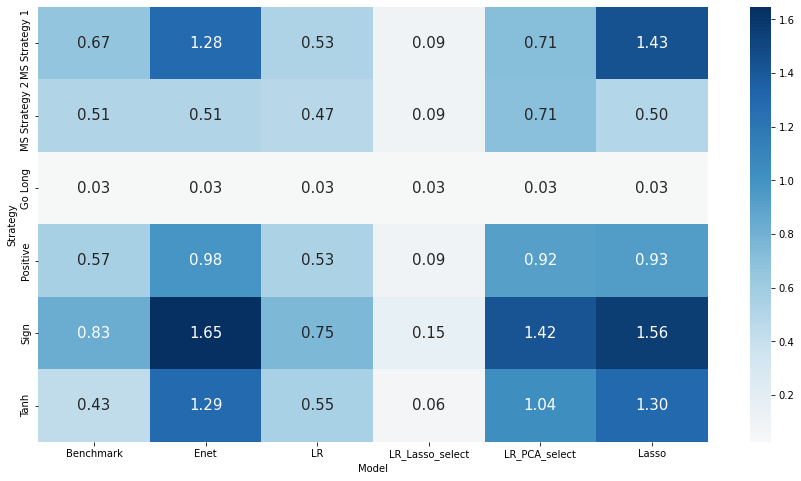

In [95]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="Sharpe")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df.rename(index = {"Market": "Go Long"}),
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

### Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

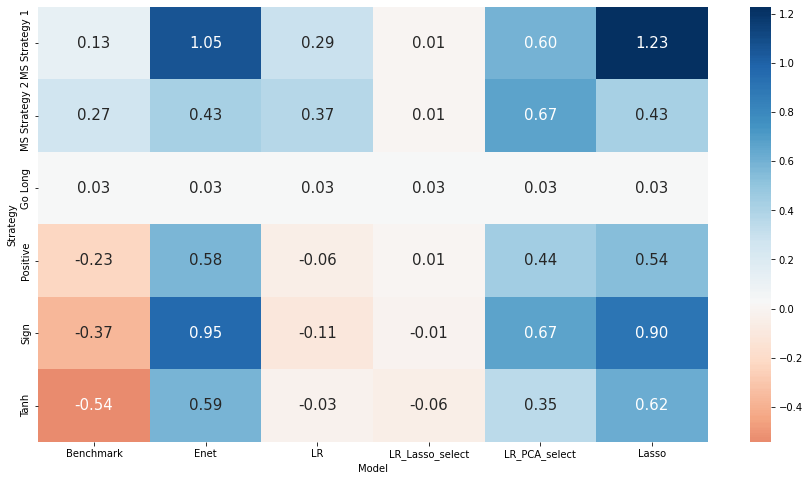

In [96]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="SharpeAdj")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df.rename(index = {"Market": "Go Long"}),
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

## Returns

### No Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

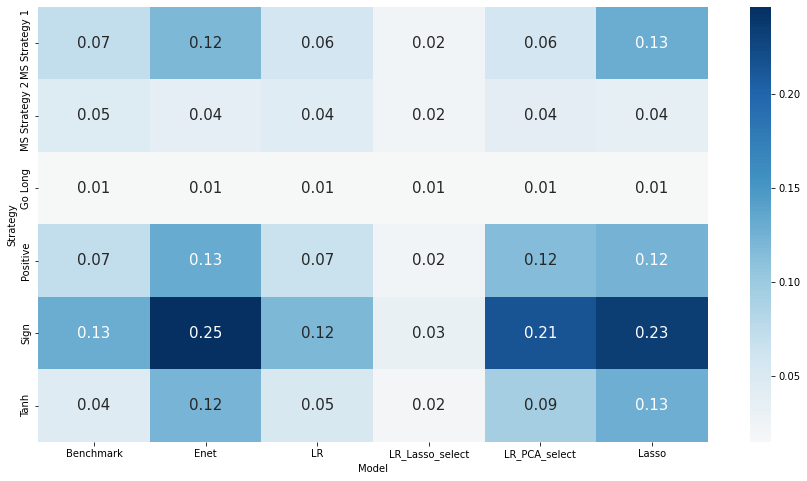

In [97]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="Return")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df.rename(index = {"Market": "Go Long"}),
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

### Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

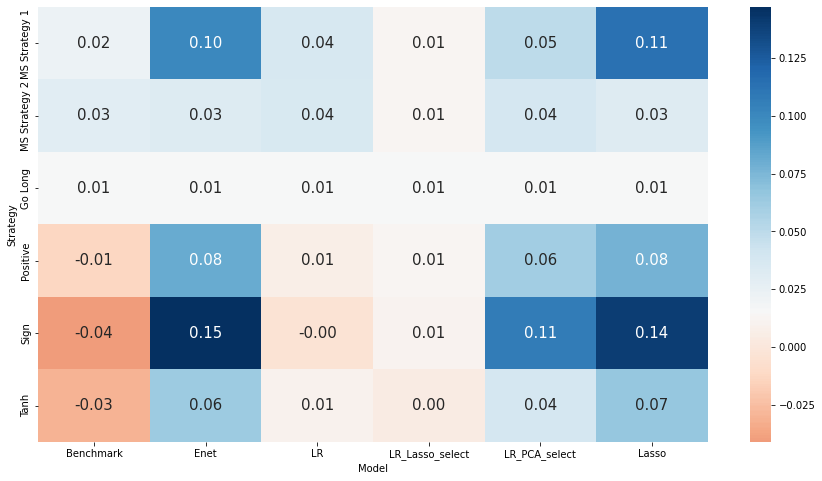

In [98]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="ReturnAdj")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df.rename(index = {"Market": "Go Long"}),
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

## Turnover

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

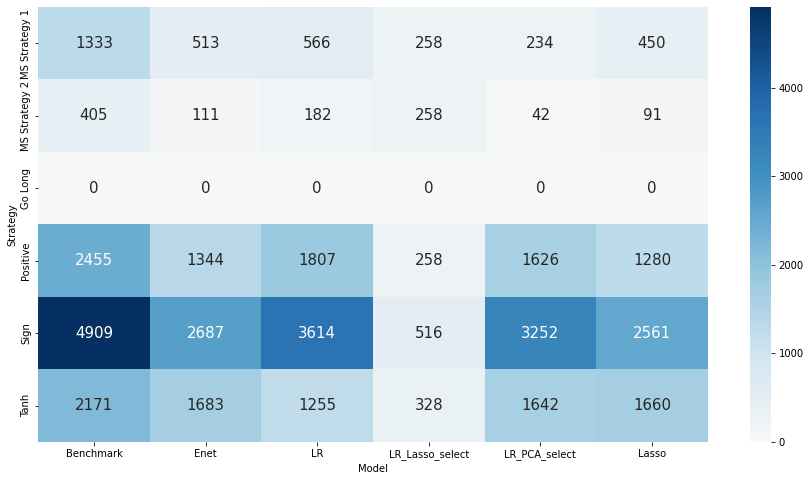

In [99]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="Trades")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df.rename(index = {"Market": "Go Long"}),
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".0f",
    annot=True,
    annot_kws={"fontsize": 15},
)

## Metrics Table

In [34]:
# Params
table_loc = '!h' # Should be something like htbp
table_fontsize = 'footnotesize'
table_precaption = 'Performance Results'

# Useful vars
metrics_list = ["Return", "ReturnAdj", "Sharpe", "SharpeAdj", "Trades", "rvol"]
metrics_names_list = ['Return', 'Adjusted Return', 'Trades', 'Sharpe', 'Adjusted Sharpe', 'Realized Volatility']

# Get pivotted dataframe with index being the strategy
# and columns being a muiltilevel consisting of (metric, model)
# Also format stratgies and models into a particular order
oss_results_all_fmt_df = oss_results_all_df.copy()
oss_results_all_fmt_df["Name"] = pd.Categorical(
    oss_results_all_fmt_df["Name"], categories=model_list, ordered=True
)
oss_results_all_fmt_df.index = pd.Categorical(
    oss_results_all_fmt_df.index, categories=strategies_list, ordered=True
)
pivot_allmetrics_df = oss_results_all_fmt_df.rename_axis(index="Strategy").pivot(
    columns="Name", values=metrics_list
)

for metric_idx, metric in enumerate(metrics_list):
    pass

# Get pivot table for a particular metric
pivot_metric_df = pivot_allmetrics_df[metric].copy()
pivot_metric_df.columns = pd.MultiIndex.from_tuples(
    [(x.split("_")[0], " ".join(x.split("_")[1:2])) for x in pivot_metric_df.columns]
).set_names(["Model", "Selection"])

# Convert to latex table
pd_latex_table = pivot_metric_df.rename_axis(index = None).to_latex(multicolumn=False, sparsify=False)

# Computed parameters
table_caption = table_precaption + ": " + metrics_names_list[metric_idx]
table_label = (
    table_precaption.lower().replace(" ", "_")
    + "_"
    + results_folder_name
    + "_"
    + metric.lower()
)

pd_latex_table_fmtd = format_pd_latex_table(pd_latex_table, table_caption, table_fontsize, table_label, ' ')

In [36]:
print(pd_latex_table_fmtd)


\begin{table}[!h]
\footnotesize
\centering
\caption{Performance Results: Realized Volatility}
\label{tab:performance_results_main_smb_rvol}
\begin{threeparttable}
\begin{tabular}{lrrrrrr}
\toprule
\toprule
Model & Benchmark &    LR &    LR &    LR & Lasso &  Enet \\
Selection &           &       &   PCA & Lasso &       &       \\
\midrule
Market          &      0.08 &  0.08 &  0.08 &  0.08 &  0.08 &  0.08 \\
Sign            &      0.08 &  0.08 &  0.08 &  0.08 &  0.08 &  0.08 \\
Positive        &      0.06 &  0.06 &  0.06 &  0.06 &  0.06 &  0.06 \\
Tanh            &      0.04 &  0.04 &  0.04 &  0.04 &  0.04 &  0.04 \\
MS Strategy 0.9 &      0.04 &  0.04 &  0.04 &  0.04 &  0.04 &  0.04 \\
MS Strategy 0.5 &      0.06 &  0.05 &  0.05 &  0.05 &  0.05 &  0.05 \\
\bottomrule
\bottomrule
\end{tabular}
\begin{tablenotes}[flushleft]
\item\textit{Note:}  
\end{tablenotes}
\end{threeparttable}
\end{table}



# Scratch

In [102]:
temp_df = pd.concat(
    [
        pd.read_parquet(x, columns=["ff__mkt", "ff__smb"])
        for x in glob.glob(f"{results_tools.hfzoo_return_folder}/*_all.parquet")
    ]
)

In [153]:
temp_df = pd.read_parquet(glob.glob('../../../../GitHub/HFZoo/data/proc/factor_returns_with_jumpind_5min/*_all.parquet'), columns = ['ff__mkt', 'ff__smb', 'ff__hml', 'ff__rmw', 'ff__cma', 'ff__umd']).sort_index()

In [154]:
temp_df['ff__mkt_lag'] = temp_df['ff__mkt'].shift(1)
temp_df['ff__mkt_lag_2'] = temp_df['ff__mkt'].shift(2)
temp_df['ff__mkt_lag_3'] = temp_df['ff__mkt'].shift(3)


In [155]:
# Target factor
factors_ff6 = ["ff__mkt", "ff__smb", "ff__hml", "ff__rmw", "ff__cma", "ff__umd"]

for factor in factors_ff6:

    temp_df[f"{factor}_lag"] = temp_df[factor].shift(1)

for factor_target in factors_ff6:

    # Temp_df is dataframe with 5-minute returns on factors
    temp_insample_df = temp_df.loc[:"2000"]
    temp_outofsample_df = temp_df.loc["2000":]

    # Market lag as predictor
    fit = smf.ols(
        f"{factor_target} ~ " + " + ".join([x + "_lag" for x in factors_ff6]), temp_insample_df
    ).fit()

    # Market lag as predictor
    predicted = fit.predict(temp_outofsample_df)
    r2 = compute_rsquared(temp_outofsample_df[factor_target], predicted)

    print(f"{factor_target}: {r2:.2%}")

ff__mkt: -0.35%
ff__smb: 3.79%
ff__hml: 1.57%
ff__rmw: 1.60%
ff__cma: -1.77%
ff__umd: 2.62%


## HF Lit

In [127]:
import scipy.io

In [128]:
# Load all high-frequency factors from AKX
hflit_factor_list = []

for mat_file in tqdm(glob.glob("../../../../GitHub/HFZoo/data/akx/hffactors/*.mat")):

    # Get factor name
    mat_factor_name = mat_file.split('.mat')[0][-3:]
    
    # Read in data
    mat = scipy.io.loadmat(mat_file)
    hflit_factor_temp_df = pd.DataFrame(mat["Data"], columns=["date", "time", "ret"])
    hflit_factor_temp_df["datetime"] = pd.to_datetime(
        hflit_factor_temp_df["date"].astype(int).astype(str)
        + " "
        + hflit_factor_temp_df["time"].astype(int).astype(str),
        format="%Y%m%d %H%M%S",
    )
    hflit_factor_temp_df["date"] = pd.to_datetime(hflit_factor_temp_df["date"], format="%Y%m%d")
    
    # Add cumulative return
    hflit_factor_temp_df = hflit_factor_temp_df.sort_values(by = 'datetime')
    hflit_factor_temp_df[mat_factor_name + '_cumret'] = (1+hflit_factor_temp_df['ret']).cumprod()/(1+hflit_factor_temp_df['ret'].iloc[0])
    
    # Add to list
    hflit_factor_list.append(hflit_factor_temp_df)

  0%|          | 0/6 [00:00<?, ?it/s]

In [133]:
from functools import reduce 

In [134]:
# Clean up
hflit_df = reduce(
    lambda left, right: pd.merge(
        left,
        right.drop(["ret"], axis=1),
        on=["date", "time", "datetime"],
        how="outer",
    ),
    hflit_factor_list,
).drop(["ret"], axis=1)
hflit_df = hflit_df.sort_values(by = 'datetime')
hflit_daily_df = hflit_df.groupby('date').last().reset_index()

for factor in ['mkt', 'smb', 'hml', 'rmw', 'cma', 'umd']:
    hflit_df[f'{factor}_cumret'] = hflit_df[f'{factor}_cumret']/hflit_df[f'{factor}_cumret'].iloc[0]
    hflit_df[f'{factor}'] = hflit_df[f'{factor}_cumret'].pct_change()
    hflit_daily_df[f'{factor}_cumret'] = hflit_daily_df[f'{factor}_cumret']/hflit_daily_df[f'{factor}_cumret'].iloc[0]
    hflit_daily_df[f'{factor}'] = hflit_daily_df[f'{factor}_cumret'].pct_change()

In [137]:
temp_df = hflit_df.set_index('datetime').copy()

In [140]:
# Target factor
factors_ff6 = ["mkt", "smb", "hml", "rmw", "cma", "umd"]

for factor in factors_ff6:

    temp_df[f"{factor}_lag"] = temp_df[factor].shift(1)

for factor_target in factors_ff6:

    # Temp_df is dataframe with 5-minute returns on factors
    temp_insample_df = temp_df.loc[:"2010"]
    temp_outofsample_df = temp_df.loc["2010":]

    # Market lag as predictor
    fit = smf.ols(
        f"{factor_target} ~ " + " + ".join([x + "_lag" for x in factors_ff6]), temp_insample_df
    ).fit()

    # Market lag as predictor
    predicted = fit.predict(temp_outofsample_df)
    r2 = compute_rsquared(temp_outofsample_df[factor_target], predicted)

    print(f"{factor_target}: {r2:.2%}")

mkt: -0.16%
smb: 1.54%
hml: 0.99%
rmw: -0.01%
cma: -0.43%
umd: 2.18%
